In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import nltk

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, LSTM, GRU, Bidirectional, SpatialDropout1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Model
from keras.initializers import Constant

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split

import nltk.corpus
import string
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
from keras.layers import Embedding

seed_value= 123
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value) 


In [2]:
df = pd.read_csv('TrainData.csv')
df_test = pd.read_csv('Assignment4_TestLabels.csv')

In [3]:
df_test.head()

,ArticleId,Text,Category
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport


In [4]:
df.head()

,Text,Category
0,worldcom ex-boss launches defence lawyers defe...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in $168m payout eighteen former e...,business


In [5]:
y_train = df['Category']
X_train = df.drop(['Category'],axis=1)
X_train = X_train.reset_index(drop=True)

y_test = df_test['Category']
X_test = df_test.drop(['ArticleId', 'Category'],axis=1)

print('before: %s ...' %y_train[:5])

#Transform label names to unique number using label encoder
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print('after: %s ...' %y_train)

before: 0    business
1    business
2    business
3        tech
4    business
Name: Category, dtype: object ...
after: [0 0 0 ... 0 4 4] ...


In [6]:
X_test

,Text
0,qpr keeper day heads for preston queens park r...
1,software watching while you work software that...
2,d arcy injury adds to ireland woe gordon d arc...
3,india s reliance family feud heats up the ongo...
4,boro suffer morrison injury blow middlesbrough...
...,...
730,eu to probe alitalia state aid the european ...
731,u2 to play at grammy awards show irish rock ba...
732,sport betting rules in spotlight a group of mp...
733,alfa romeos to get gm engines fiat is to sto...


In [8]:
print(np.bincount(y_train))
print(le.inverse_transform([i for i in range(5)]))

[336 273 274 346 261]
['business' 'entertainment' 'politics' 'sport' 'tech']


In [10]:
def preprocess(X):
  return X.map(lambda x: x.lower().split("\n")).map(lambda x: [y.split(". ") for y in x]).map(lambda x: [i.replace('\'','') for sl in x for i in sl if i is not ''])

In [11]:
X_train

,Text
0,worldcom ex-boss launches defence lawyers defe...
1,german business confidence slides german busin...
2,bbc poll indicates economic gloom citizens in ...
3,lifestyle governs mobile choice faster bett...
4,enron bosses in $168m payout eighteen former e...
...,...
1485,double eviction from big brother model caprice...
1486,dj double act revamp chart show dj duo jk and ...
1487,weak dollar hits reuters revenues at media gro...
1488,apple ipod family expands market apple has exp...


In [167]:
X_train['text'] = preprocess(X_train['Text'])
X_test['text'] = preprocess(X_test['Text'])

In [168]:
import re

lemmatizer = WordNetLemmatizer()
stopw = nltk.corpus.stopwords.words('english')
punct = string.punctuation
punct = word_tokenize(punct)
punct += ['``','...','\'s','--','-','n\'t','\'']
stopw += punct
def token_stop(text):
    global stopw
    global lemmatizer
    words = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in words if not w in stopw]
    return filtered
  
X_train['text'] = X_train['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])
X_test['text'] = X_test['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])

In [169]:
texts = np.array(X_train['text'])
test_text = np.array(X_test['text'])

In [172]:
max_seq_len= 500
max_words = 20000

tokenizer = Tokenizer(nb_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

len_max=0
grt = 0
for i in sequences:
    len_max = max(len_max, len(i))
    if len(i)>400:
        grt += 1

print('max len: ',len_max)
print('grt : ', grt)

data = pad_sequences(sequences, maxlen=max_seq_len)

labels = to_categorical(np.asarray(y_train))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

#Split training and validation data with 20% split. So final is training 64%, validation 16% and test 20% of whole data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

xtrain = data
ytrain = labels
# xval = data[-nb_validation_samples:]
# yval = labels[-nb_validation_samples:]

/raid/home/devarajuv/anaconda3/envs/robotenv/lib/python3.7/site-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 25316 unique tokens.
max len:  1643
grt :  73
Shape of data tensor: (1490, 500)
Shape of label tensor: (1490, 5)


In [143]:
# from gensim import models

# embeddings_index_word2vec = dict()
# embeddings_index_word2vec = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

vocab_size = len(word_index)+1
cnt = 0
embedding_matrix_word2vec = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    try:
        embedding_matrix_word2vec[i] = embeddings_index_word2vec[word]
    except:
        cnt += 1
        print(word)
        
print(cnt)

.
000
labour
2004
2005
10
2003
programme
e-mail
centre
20
12
100
2001
yukos
50
11
30
2002
15
ukip
organisation
2006
..
40
2000
favourite
18
25
theatre
defence
14
kilroy-silk
honour
13
16
24
criticised
17
favour
200
worldcom
mci
so-called
briton
high-definition
70
blunkett
500
offence
19
60
foxx
behaviour
23
hodgson
ebbers
long-term
1999
1997
80
6-3
henman
milburn
27
anti-virus
90
kenteris
iaaf
22
colour
organiser
radcliffe
wi-fi
dallaglio
gazprom
hip-hop
45
1994
1980s
1998
21
half-time
26
staunton
28
6-2
clive
thanou
woodward
2008
henson
eastwood
bafta
boerse
29
7-6
khodorkovsky
scorsese
moya
100m
file-sharing
rosneft
jeeves
organised
6-1
rumour
000m
driscoll
davy
parmalat
fly-half
agassi
yugansk
line-up
1990s
34
dicaprio
7-5
rusedski
300
imelda
6-4
recognised
2007
apologise
150
heineken
high-speed
36
mirza
souness
250
hague
uwb
65
31
twickenham
2010
hi-tech
800
callaghan
60m
600
baikal
realise
200m
75
800m
lewsey
fockers
peer-to-peer
runner-up
1993
corry
no-one
gloucester
munster
qant

neighbourhood
550
non-profit
kenenisa
equalled
lammy
koubek
unfavourable
psps
rightmove
coogan
investec
bail-out
fratton
four-month
razorlight
glamour
cotonsport
pre-budget
£52m
fuelling
ex-labour
2200
babyshambles
2.1
klinsmann
5.5
re-released
jean-pierre
luxembourg
nine-year
all-singing
all-dancing
dvb-h
mccaughrean
symmons
geoffrey
unauthorised
hard-fought
match-winning
aynsley-green
1942
1957
24-hour
re-drafted
quaid
27.5bn
rnid
fixed-line
babayaro
right-back
norah
taipei
tunisia
8-1
mclennan
eliot
06/05
ofheo
4.6
£30
4.8
capitalised
neath-swansea
half-blood
idec
archibald
esson
mackie
five-month
oldham
internationalised
ukif
idn-disabled
£22m
forster
longer-term
iea
al-qaeda
obermann
full-year
radicati
1964
woodford
ealing
zafi
super-casinos
£180
sending-off
guildford
balado
shiga
learnt
anson
low-paid
quashie
one-time
shakur
ginepri
hobday
on-going
bondi
grandclaude
lamboley
yann
frederic
traille
jauzion
julien
laharrague
marconnet
betsen
nyanga
back-ups
ptc
tamimi
one-third
paid

inoni
climan
ex-minister
fervour
modernisation
25bn
£5bn
super-rich
felgate
amritsar
walliams
dibley
rhode
small-budget
cristie
gondry
denial-of-service
pipex
cruyff
£13bn
groenefeld
voigt
non-technical
pre-christmas
ambuja
164
johannesson
148
over-55s
028
in-court
co-parenting
pro-shift
pararallying
rainey
wambo
erdogan
co-operates
yugoslavia
easy-to-use
jean-francois
theodore
london-frankfurt
back-tax
atomstroieksport
alcobev
plante
newbury
mid-80s
14m
one2one
revolutionising
dvrs
buckinghamshire
43-year-old
futureheads
woodhill
garros
majumdar
record-holder
25.7
congressionally-mandated
usatf
non-market
16-year-olds
post-world
stand-out
pc-based
940
connectotel
travelodge
mcewen-king
hirsch
psv
eindhoven
maldini
half-way
x-men
£857m
mcclelland
kick-off
naysmith
hibbert
shailendra
non-commercial
bethan
ex-russian
£65
1.76
centring
charcote
£8
42-6
1701
scott-joynt
all-round
embu
isaiah
three-time
edith
630m
66m
87-year-old
poiter
attallah
shabazz
remote-controlled
out-and-out
lualua


co-operating
attorney-general
shake-out
cherkasky
529
60-employee
£1.1m
£428m
bailin
rymer
hannigan
redgate
amuro
dutch-moroccan
self-image
booy
6-5
double-faulted
serve-and-volley
andreev
up-to-date
non-government
self-sustainable
huaral.org
50-family
mini-hydraulic
2kw
6.25
5.80
billion-plus
jolt.co.uk
co-manages
16-28
3-5
pro-gaming
cyberathlete
10-13
counter-strike
one-one-one
morehouse
denzel
armando
4.4bn
1/14
endemol
2/9
1.41
813
296
28.52
9.7
3.24
ostwald
texas-based
£5.18bn
khordokovsky
reveta
disney-owned
thomsen
krim
easy-to-play
big-hitting
puzzle-based
sports-based
over-50
hi-spec
realarcade
games-on-demand
artificially-inflated
pay-outs
zonealarm
40-odd
it-literate
£320
92-cap
one-season
ultimitely
adaptibility
lock-cum-flanker
50-44
pre-order
terrell
hogwarts
yvette
£25m
cottenham
cambridgeshire
minety
ireland-based
tysabri-treated
re-initiation
four-fold
goodbody
18.90
28.63
38.65
19.84
151.5
yamanouchi
daveport
14-year-olds
yoxall
singer-songwriters
feargal
sharkey
luc

pompei
two-part
genghis
belsen
fingersmith
burchill
bex
ronnies
midsomer
marple
epipsodes
wiedersehen
under-achievement
self-defence
sugababes
144m
290
probyn
36-page
£12bn
2007-2008
banos
monteiro
6.6km
keska
10.6km
31:41
30.26
abebe
dinkessa
33.22
gelete
30.2m
£15.5m
spanglish
connelly
olaf
on-board
multi-purpose
pre-packaged
dual-screen
5000
higher-priced
nokia-sponsored
bdb
4.25
bush/kerry
multi-discipline
uruguayan-born
newsgaming.com
cambiemos
phone-taps
alyona
see-saw
love-in
billingsgate
mind-bending
side-door
doo-style
dressing-up
ill-at-ease
soberly-suited
side-by-side
gillian
cathal
corkman
pre-olympic
costin
meseret
cobhwoman
brizzel
21.00
injury-plagued
3:39
catherina
dermot
injury-ravaged
annadale
athletics-loving
bremner
widely-predicted
over-abrupt
radley
145
konami
lma
gt4
£530m
94m
parmjit
six-kilometre
damen
glynn
tromans
inter-countries
1.3516
1.3509
1.35
euro/dollar
1.40
21bn
£10.8bn
abdullatif
16.5bn
33.5bn
over-egged
moghadam
deppler
set-to
fly-half-cum-centre
53

In [144]:
# embeddings_index_fasttext = dict()

# with open('crawl-300d-2M.vec') as f:
#     for line in f:
#         word, coefs = line.split(maxsplit=1)
#         coefs = np.fromstring(coefs, 'f', sep=' ')
#         embeddings_index_fasttext[word] = coefs

# print('Found %s word vectors.' % len(embeddings_index_fasttext))

cnt = 0
embedding_matrix_fasttext = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    try:
        embedding_matrix_fasttext[i] = embeddings_index_fasttext[word]
    except:
        
        cnt += 1
        print(word)
        
print(cnt)

yukos
kilroy-silk
blunkett
ebbers
kenteris
iaaf
dallaglio
gazprom
thanou
boerse
khodorkovsky
rosneft
parmalat
yugansk
rusedski
souness
lewsey
lleyton
kuznetsova
mcilroy
euronext
yuganskneftegas
letwin
peston
hiv/aids
mubanga
aragones
clijsters
chepkemei
£1
gudjohnsen
melzer
easterby
9/11
lewis-francis
wright-phillips
fightstar
nistelrooy
yachvili
£2
oscar-nominated
marigny
hockney
us-based
£100
jowell
saulnier
borussia
csos
henin-hardenne
turkcell
xstrata
daimlerchrysler
luscombe
itv1
mauresmo
£10
horgan
bortolami
hoddle
tzekos
£5
ghosn
latinohiphopradio.com
simonetti
kezman
myskina
dechy
morquendi
ancram
£50
kinnock
tautou
southcorp
michalak
mcleish
sotherton
guerrouj
shanklin
orquera
bergamasco
£35bn
ufj
lanzone
negroponte
knapman
cudicini
elgindy
exeem
murrayfield
hantuchova
molik
£4m
vickery
sizzla
sidoli
nitoglia
£500
£35
menatep
arnesen
kapranos
bekele
cluley
£1.3bn
belmarsh
odpm
delaigue
bogdanovic
scarman
bofra
jamelia
purushotma
villalba
uk-based
£20
magnier
£200
houllier
kluf

verroken
£1.34bn
moorcroft
palookaville
rnib
chakkara
non-indian
wanless
suprnova.org
novastream
ebber
munich-based
weidensteiner
hans-werner
globescan
£89m
lerach
£378.8m
fastow
2001alleging
truanted
o-levels
donnedieu
785m
784m
142bn
schrempp
daimerchrysler
44.7m
£23.2m
121.9m
£63.3m
165.8m
£86.1m
£6.5m
12.7m
£6.6m
£51.6m
£1.30
£1.18
16.2bn
£8.7bn
17.5bn
uk-listed
548p
3.65bn
£1.97bn
2.89bn
3.997
munsterman
hill-wood
hewson
ireland-only
speaker-climbing
drum-throwing
macphisto
likhotseva
eighth-seed
v603sh
ph-s6500
sports-leisure
cazalets
baltacha
oganesyan
bjorkman
daniilidou
frenchwoman
youzhny
zuluaga
golovin
dulko
pennetta
175.6bn
£93.6bn
14.3bn
14.1bn
computer-augmented
magnenat-thalman
miralab
broadus
congdon
market-set
deshui
auxerre
slushier
action-fest
gormenghast
stollenmayer
markova-dolin
sylphides
ruigang
china-watcher
jeanne-marie
bridgewell
westfallen
£47m
27.2m
134.7m
peter-thilo
halser
schechter
destatis
coruna
depor
irureta
shadowcrew.com
tyukanov
darkprofits
soccere

laxton
sanzar
gregan
£138m
restructuing
marson
hypertags
lueders
utgoff
wiesenthal
£250
firstsaver
r85
non-taxpayer
£546m
1.04bn
£532m
omnicom
cordiant
rubicam
tarantino-directed
howley
349.4bn
£265.9bn
aburizal
previously-pledged
alwi
272-219
161-strong
mis-transcription
1.3652
1.3667
102.55
management-chicago
mackel
1956-87
shefrin
frankin
mirvish
varttina
warchus
radicallyimproved
grumbletext.co.uk
050-1
ex-travel
£230.8m
have-nets
loose-forward
brockstein
rivaldo
kluivert
al-gharafa
gullit
vialli
abramovich
lebeouf
batistuta
dugarry
£13.8m
336m
stafford-smith
aberdeen-based
baathist
baghdad-based
kirkuk
geo-scientists
anti-radio
doping-related
spyware-removal
gmtv
birkenhead
17.6m
£9.49m
72-500
bagnato
phinnaeus
cleese
buscemi
winick
naude
10.04secs
20.13secs
cross-europe
over-emphasises
theriault
pence-per-share
luxembourg-based
1.4850
silliere
questionsmarks
netherlands-based
indian-born
ispat
£16.7bn
24.1bn
2+2=5
£21.5m
£392.1m
amibitions
welsh-english
airlines-
flight-crew
gaob

In [145]:
# # load the whole embedding into memory
# embeddings_index_glove = dict()
# f = open('glove.840B.300d.txt','r', encoding="utf-8", errors = 'ignore')
# cnt=0
# for line in f:
#     if(cnt<5):
#         print(line)
#     cnt += 1
#     values = line.split()
#     word = ''.join(values[:-300])
#     coefs = np.asarray(values[-300:], dtype='float32')
#     embeddings_index_glove[word] = coefs
# f.close()
# print('Loaded %s word vectors.' % len(embeddings_index_glove))


cnt = 0
embedding_matrix_glove = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    try:
        embedding_matrix_glove[i] = embeddings_index_glove[word]
    except:
        cnt += 1
        print(word)
        
print(cnt)

yukos
kilroy-silk
blunkett
ebbers
kenteris
dallaglio
thanou
boerse
khodorkovsky
rosneft
parmalat
yugansk
rusedski
souness
lewsey
yuganskneftegas
letwin
peston
mubanga
aragones
chepkemei
£1
gudjohnsen
melzer
easterby
lewis-francis
wright-phillips
yachvili
£2
oscar-nominated
marigny
£100
saulnier
csos
henin-hardenne
luscombe
£10
bortolami
hoddle
tzekos
£5
ghosn
latinohiphopradio.com
kezman
dechy
morquendi
ancram
£50
kinnock
southcorp
michalak
cabir
sotherton
guerrouj
orquera
bergamasco
£35bn
ufj
lanzone
knapman
cudicini
elgindy
exeem
molik
£4m
sidoli
nitoglia
milanesi
£500
£35
menatep
arnesen
kapranos
cluley
£1.3bn
belmarsh
odpm
delaigue
bogdanovic
scarman
bofra
purushotma
villalba
£20
magnier
£200
1.5bn
houllier
kluft
bosvelt
gizmondo
£1bn
toshack
furse
clearstream
castaignede
ceplak
mcbryde
ljubicic
hopman
pelous
1.2bn
sheahan
£4bn
niesr
gammell
idowu
hartson
icstis
mccririck
yuganskneftegaz
sonaptic
£25
four-kings
1.8bn
holcim
pountney
prutton
morientes
speegle
charvis
contepomi
£3bn


soccerex
ofex
000-seater
nigerian-owned
paschi
oftexas
non-solicited
islero
manolete
illston
korchemny
ilston
baldini
jaouad
tergat
£117m
jiulin
late-november
tetsuro
tsusaka
mclibel
saparmurat
naftohaz
boyko
saffo
540bn
£2.77bn
daimlerchrylser
nishioka
472bn
islamaphobia
sayeeda
nasdaq-100
henley-on-thames
j-flag
jammins
mutola
oyepitan
behind-closed
ex-aides
molly-coddled
shoot-anything-that-moves
cannon-toting
hykeham
293.5p
anglo-dutch
kimberly-clark
£173m
condom-maker
syndol
meltus
dingolfing
sindelfingen
ryanair/boeing
bonderman
six-try
barbini
1.47m
£140bn
258bn
cosgrave
1.4ghz
audio/headphone
jack.the
2.6ghz
£469
1.8ghz
buildyourown.org.uk
obtain/build
trouble-hit
plane-making
beaudoin
montreal-based
trichet
berson
poor-rating
£96bn
£3.8bn
28.4bn
split-caps
£799
chemicals-and-crops
jakarta-based
£24bn
74.7bn
useful/popular
magath
tateson
waarschuwingsdienst
open-era
swiss-german
sunovate
southernplayalisticadillacmuzik
stakonia
ex-england
amibition
cunanan
3.4m
2001fetched
£5.5

wolfensohn
shinawatra
juthamas
siriwan
vassilli
413.50
113.5m
£18.8bn
mukerjee
mikoyan-gurevich
keskar
£291m
eliud
9.2km
gebre
gebremariam
dejene
berhanu
lasp
6.2km
8.5bn
£4.4bn
£5.4
£3.1bn
£24.8bn
£27.9bn
£16.9bn
£36.3bn
£1.9bn
£2.7bn
£2.9bn
trade-in-services
confifi
gresik
ex-bbc
anti-islamism
-silk
anti-european
rk-s
self-publicising
pro-europeans
anti-europeans
euro-enthusiast
coup-d
straight-down-the-middle
dangerous.the
anti-europe
too-twee
pakeerah
£458m
874m
67.7m
35.1m
honeyman-scott
farndon
piano-pounder
£1.4m
eu-us
freight-carrying
a380s
quirksville
anti-blogging
euskarians
price-prohibitive
myrio
c-cor
£5.3bn
uk-issued
£402.4m
£116.4m
cullumpton
wolstenholme
£280.2m
532m
£450.7m
325.5p
458.5p
shadjareh
sacranie
us-registered
912km
vlore
euro-atlantic
eximbank
3.5bn
rajapakse
solheim
pre-tsunami
barrioneuvo
sturrock
fullarton
246bn
8.4bn
arnoldo
pro-chavez
kunzru
ronaldino
wanderley
luxemburgo
israeli-egyptian
kefa
ssempgani
mukasa
liebenberg
671.7bn
£484bn
496.5bn
162bn
£56

In [146]:
def build_vocab(texts):
    sentences = texts
#     .apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]
    print("number of unknown words: ",nb_unknown_words)
    return unknown_words

In [147]:
import operator
from tqdm import tqdm
tqdm.pandas()

print("coverage for fasttext: ")
vocab = build_vocab(X_train['text'])
oov_ft = check_coverage(vocab, embeddings_index_fasttext)

print("\ncoverage for word2vec: ")
vocab = build_vocab(X_train['text'])
oov_w2v = check_coverage(vocab, embeddings_index_word2vec)

print("\ncoverage for glove: ")
vocab = build_vocab(X_train['text'])
oov_glove = check_coverage(vocab, embeddings_index_glove)

coverage for fasttext: 
Found embeddings for 86.00% of vocab
Found embeddings for  97.67% of all text
number of unknown words:  7673

coverage for word2vec: 
Found embeddings for 63.77% of vocab
Found embeddings for  90.15% of all text
number of unknown words:  32391

coverage for glove: 
Found embeddings for 87.36% of vocab
Found embeddings for  98.01% of all text
number of unknown words:  6528


In [148]:
oov_ft

[('yukos', 120),
 ('kilroy-silk', 74),
 ('blunkett', 49),
 ('ebbers', 45),
 ('iaaf', 43),
 ('kenteris', 43),
 ('dallaglio', 41),
 ('gazprom', 40),
 ('thanou', 34),
 ('boerse', 33),
 ('khodorkovsky', 32),
 ('rosneft', 29),
 ('parmalat', 28),
 ('yugansk', 27),
 ('rusedski', 26),
 ('souness', 24),
 ('lewsey', 22),
 ('euronext', 20),
 ('mcilroy', 20),
 ('kuznetsova', 20),
 ('lleyton', 20),
 ('letwin', 19),
 ('yuganskneftegas', 19),
 ('mubanga', 18),
 ('hiv/aids', 18),
 ('peston', 18),
 ('chepkemei', 17),
 ('clijsters', 17),
 ('aragones', 17),
 ('gudjohnsen', 16),
 ('£1', 16),
 ('fightstar', 15),
 ('wright-phillips', 15),
 ('lewis-francis', 15),
 ('9/11', 15),
 ('easterby', 15),
 ('melzer', 15),
 ('jowell', 14),
 ('£100', 14),
 ('us-based', 14),
 ('hockney', 14),
 ('marigny', 14),
 ('oscar-nominated', 14),
 ('£2', 14),
 ('yachvili', 14),
 ('nistelrooy', 14),
 ('xstrata', 13),
 ('turkcell', 13),
 ('henin-hardenne', 13),
 ('csos', 13),
 ('borussia', 13),
 ('saulnier', 13),
 ('kezman', 12),
 (

In [100]:
# np.save("../custom_embeding_matrix.npy", custom_embeding_matrix)
# np.save("../embedding_matrix_word2vec.npy", embedding_matrix_word2vec)
# np.save("../embedding_matrix_fasttext.npy", embedding_matrix_fasttext)
# np.save("../embedding_matrix_glove.npy", embedding_matrix_glove)
# np.save("../custom_embedding_matrix_w2v.npy", embedding_matrix_word2vec)
# np.save("../custom_embedding_matrix_ft.npy", embedding_matrix_ft)

# custom_embeding_matrix = np.load('../custom_embeding_matrix.npy')
# embedding_matrix_word2vec = np.load('../embedding_matrix_word2vec.npy')
# embedding_matrix_fasttext = np.load('../embedding_matrix_fasttext.npy')
# embedding_matrix_glove = np.load('../embedding_matrix_glove.npy')
# custom_embedding_matrix_w2v = np.load('../custom_embedding_matrix_w2v.npy')
# custom_embedding_matrix_ft = np.load('../custom_embedding_matrix_ft.npy')

In [149]:
# custom_embeding_matrix = np.array(custom_embed.get_weights())[0]
custom_embeding_matrix.shape

(23218, 300)

In [150]:
labels_index = {}
for i in range(5):
  name = le.inverse_transform([i])[0]
  labels_index[name] = i
labels_index

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [152]:
from sklearn.metrics import f1_score

def find_test_acc(prediction):
  y_pred = []
  count = 0
  t = 0
  for pred in prediction:
    p = pred.argmax()
    name = le.inverse_transform([p])
    y_pred.append(name[0])
#     print(name[0])
    if name == y_test.loc[count]:
      t+=1
    count+=1
  print('Test Accuracy:',(t/count)*100,"%")
  print('micro average f1 score: ', f1_score(y_test, y_pred, average='micro'))

def predict_test(model, len_list_embed, history):
  #Tokenize test data and apply model prediction
  sequences = tokenizer.texts_to_sequences(test_text)
  data = pad_sequences(sequences, maxlen=max_seq_len)

  print('Shape of data tensor:', data.shape)
  print('Shape of label tensor:', labels.shape)
  prediction = model.predict([data]*len_list_embed)
  find_test_acc(prediction)
  fig=plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Training Loss', 'Validation Loss'])
  plt.xlabel('Epochs ')
  plt.ylabel('Loss')
  plt.show()
  

In [156]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import LSTM, Dropout, Dense, GRU, RNN, Embedding, Bidirectional

EMBEDDING_DIM=300

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

model = Sequential()
# model.add(Embedding(len(word_index) + 1,
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix_word2vec],
#                             input_length=max_seq_len,
#                             trainable=False))
custom_embed = layers.Embedding(input_dim=len(word_index) + 1,
                   output_dim=EMBEDDING_DIM,
                   input_length=max_seq_len)
model.add(custom_embed)
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(GRU(120)))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

history = model.fit(xtrain, ytrain, validation_split=0.2, epochs=35, batch_size=32,verbose = 1,
                   callbacks=[earlystop]
                   )


Train on 1192 samples, validate on 298 samples
Epoch 1/35
1192/1192 [==============================] - ETA: 0s - loss: 1.5996 - accuracy: 0.2659

/raid/home/devarajuv/anaconda3/envs/robotenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1192/1192 [==============================] - 10s 8ms/sample - loss: 1.5996 - accuracy: 0.2659 - val_loss: 1.5571 - val_accuracy: 0.3859
Epoch 2/35
1192/1192 [==============================] - 6s 5ms/sample - loss: 0.9945 - accuracy: 0.5688 - val_loss: 0.7190 - val_accuracy: 0.6443
Epoch 3/35
1192/1192 [==============================] - 6s 5ms/sample - loss: 0.2989 - accuracy: 0.9237 - val_loss: 0.2869 - val_accuracy: 0.9094
Epoch 4/35
1192/1192 [==============================] - 6s 5ms/sample - loss: 0.0640 - accuracy: 0.9908 - val_loss: 0.2466 - val_accuracy: 0.9094
Epoch 5/35
1192/1192 [==============================] - 7s 5ms/sample - loss: 0.0108 - accuracy: 0.9992 - val_loss: 0.2045 - val_accuracy: 0.9228
Epoch 6/35
1192/1192 [==============================] - 6s 5ms/sample - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.1879 - val_accuracy: 0.9362
Epoch 7/35
1192/1192 [==============================] - 7s 6ms/sample - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.1717 - val_accur

Shape of data tensor: (735, 500)
Shape of label tensor: (1490, 5)
Test Accuracy: 96.3265306122449 %
micro average f1 score:  0.963265306122449


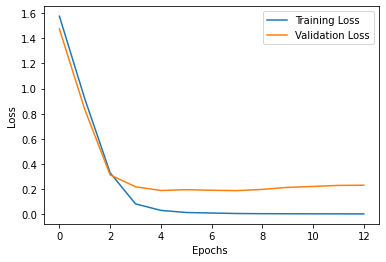

In [96]:
predict_test(model, 1, history)

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

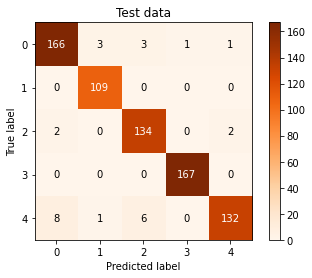

In [97]:
import scikitplot as skplt
val = 1
sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen=max_seq_len)
pred = model.predict([data]*val)
y_pred = []
for pr in pred:
    p = pr.argmax()
    y_pred.append(p)
    
(skplt.metrics.plot_confusion_matrix(y_pred, le.transform(y_test), cmap='Oranges', title="Test data"))

labels_index

In [160]:
import string
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

import tensorflow as tf
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [175]:
vocab_size = len(word_index) + 1
def DME(list_emb, maxlen):
    earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    inputs = []
    output = []
    proj_dim = 200
    num_emb = len(list_emb)
    
    for embedding in list_emb:
        inp = Input(shape=(maxlen,))
        emb = Embedding(vocab_size, 300, weights=[embedding], trainable=False)(inp)
        dense = Dense(proj_dim, activation=None)(emb)
        dense = Reshape((-1,proj_dim,1))(dense)
        inputs.append(inp)
        output.append(dense)
        
    concat = Concatenate(axis=-1)(output)
    
    project = Model(inputs, concat)

    inp = Input(shape=(maxlen, proj_dim, num_emb))
    x = Reshape((maxlen, proj_dim*num_emb))(inp)
    x = Dense(1, activation='sigmoid')(x)
    x = Reshape((maxlen, 1, 1))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    dme = Model(inp, out)

    x = dme(project.output)
    x = Conv1D(filters=64, kernel_size=5, activation='relu',
               padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(GRU(120))(x)
    out = Dense(5, activation='softmax')(x)

    dme_model = Model(project.input, out)
    dme_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return dme_model


Train on 1192 samples, validate on 298 samples
Epoch 1/35
1192/1192 [==============================] - ETA: 0s - loss: 0.9851 - accuracy: 0.6309

/raid/home/devarajuv/anaconda3/envs/robotenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1192/1192 [==============================] - 14s 12ms/sample - loss: 0.9851 - accuracy: 0.6309 - val_loss: 0.2804 - val_accuracy: 0.9161
Epoch 2/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.1420 - accuracy: 0.9522 - val_loss: 0.2997 - val_accuracy: 0.8960
Epoch 3/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0727 - accuracy: 0.9782 - val_loss: 0.0483 - val_accuracy: 0.9866
Epoch 4/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0217 - accuracy: 0.9950 - val_loss: 0.0633 - val_accuracy: 0.9832
Epoch 5/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0307 - val_accuracy: 0.9899
Epoch 6/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9899
Epoch 7/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0168 - va

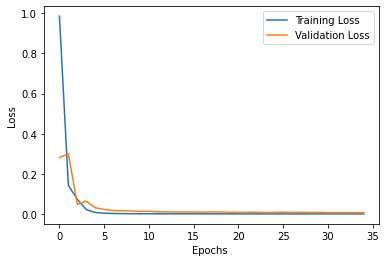

Train on 1192 samples, validate on 298 samples
Epoch 1/35
1192/1192 [==============================] - ETA: 0s - loss: 0.9414 - accuracy: 0.6351

/raid/home/devarajuv/anaconda3/envs/robotenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1192/1192 [==============================] - 14s 12ms/sample - loss: 0.9414 - accuracy: 0.6351 - val_loss: 0.3108 - val_accuracy: 0.8960
Epoch 2/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.1268 - accuracy: 0.9606 - val_loss: 0.1744 - val_accuracy: 0.9362
Epoch 3/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0723 - accuracy: 0.9815 - val_loss: 0.0616 - val_accuracy: 0.9832
Epoch 4/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0248 - accuracy: 0.9941 - val_loss: 0.0361 - val_accuracy: 0.9899
Epoch 5/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0158 - accuracy: 0.9966 - val_loss: 0.0565 - val_accuracy: 0.9832
Epoch 6/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0625 - accuracy: 0.9815 - val_loss: 0.0655 - val_accuracy: 0.9732
Epoch 7/35
1192/1192 [==============================] - 9s 8ms/sample - loss: 0.0111 - accuracy: 0.9983 - val_loss: 0.0492 - val

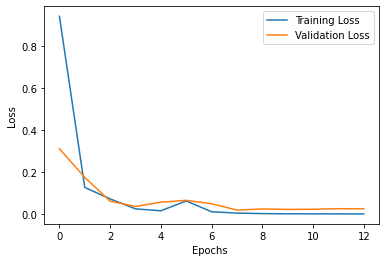

Train on 1192 samples, validate on 298 samples
Epoch 1/35
1192/1192 [==============================] - ETA: 0s - loss: 0.9786 - accuracy: 0.6216

/raid/home/devarajuv/anaconda3/envs/robotenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1192/1192 [==============================] - 15s 12ms/sample - loss: 0.9786 - accuracy: 0.6216 - val_loss: 0.3566 - val_accuracy: 0.8490
Epoch 2/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.1406 - accuracy: 0.9564 - val_loss: 0.2309 - val_accuracy: 0.9262
Epoch 3/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0565 - accuracy: 0.9799 - val_loss: 0.1252 - val_accuracy: 0.9597
Epoch 4/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0689 - accuracy: 0.9790 - val_loss: 0.1046 - val_accuracy: 0.9732
Epoch 5/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.0887 - val_accuracy: 0.9698
Epoch 6/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0868 - val_accuracy: 0.9732
Epoch 7/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0951 - va

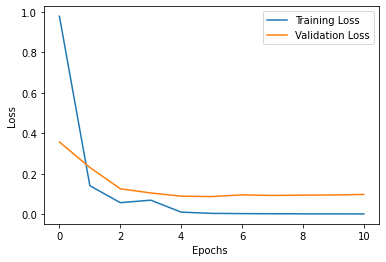

Train on 1192 samples, validate on 298 samples
Epoch 1/35
1192/1192 [==============================] - ETA: 0s - loss: 0.9836 - accuracy: 0.6183

/raid/home/devarajuv/anaconda3/envs/robotenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1192/1192 [==============================] - 15s 13ms/sample - loss: 0.9836 - accuracy: 0.6183 - val_loss: 0.2834 - val_accuracy: 0.9060
Epoch 2/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.1430 - accuracy: 0.9530 - val_loss: 0.0756 - val_accuracy: 0.9732
Epoch 3/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0436 - accuracy: 0.9916 - val_loss: 0.0712 - val_accuracy: 0.9732
Epoch 4/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0435 - accuracy: 0.9866 - val_loss: 0.1444 - val_accuracy: 0.9530
Epoch 5/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0413 - accuracy: 0.9832 - val_loss: 0.0783 - val_accuracy: 0.9799
Epoch 6/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0095 - accuracy: 0.9983 - val_loss: 0.0384 - val_accuracy: 0.9866
Epoch 7/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0196 - va

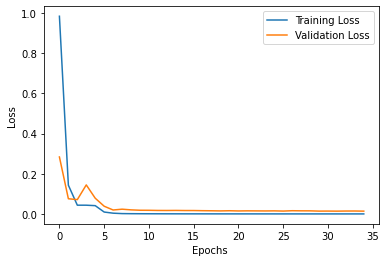

Train on 1192 samples, validate on 298 samples
Epoch 1/35
1192/1192 [==============================] - ETA: 0s - loss: 0.9260 - accuracy: 0.6510

/raid/home/devarajuv/anaconda3/envs/robotenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1192/1192 [==============================] - 15s 13ms/sample - loss: 0.9260 - accuracy: 0.6510 - val_loss: 0.2300 - val_accuracy: 0.9396
Epoch 2/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.1327 - accuracy: 0.9581 - val_loss: 0.1014 - val_accuracy: 0.9664
Epoch 3/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0508 - accuracy: 0.9883 - val_loss: 0.1238 - val_accuracy: 0.9530
Epoch 4/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0340 - accuracy: 0.9874 - val_loss: 0.1270 - val_accuracy: 0.9597
Epoch 5/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0145 - accuracy: 0.9966 - val_loss: 0.0775 - val_accuracy: 0.9765
Epoch 6/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0098 - accuracy: 0.9983 - val_loss: 0.0635 - val_accuracy: 0.9799
Epoch 7/35
1192/1192 [==============================] - 10s 8ms/sample - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0697 - va

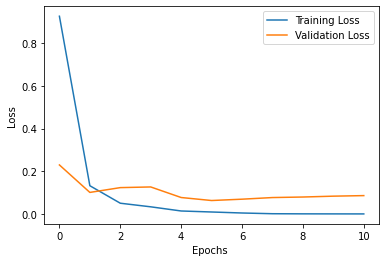

In [183]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)
for train, val in kfold.split(xtrain, ytrain):

    dme_model = DME(list_embed, maxlen=max_seq_len)
    history = dme_model.fit([xtrain[train]]*len_list_embed, ytrain[train], validation_data =([xtrain[val]]*len_list_embed, ytrain[val]),
                            epochs=35, batch_size=32,verbose = 1,
                   callbacks=[earlystop])
    predict_test(dme_model, len_list_embed, history)

Train on 1192 samples, validate on 298 samples
Epoch 1/35
1192/1192 [==============================] - ETA: 0s - loss: 0.7746 - accuracy: 0.6604

/raid/home/devarajuv/anaconda3/envs/robotenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1192/1192 [==============================] - 10s 8ms/sample - loss: 0.7746 - accuracy: 0.6604 - val_loss: 0.2110 - val_accuracy: 0.9304
Epoch 2/35
1192/1192 [==============================] - 9s 7ms/sample - loss: 0.2089 - accuracy: 0.9291 - val_loss: 0.2248 - val_accuracy: 0.9173
Epoch 3/35
1192/1192 [==============================] - 9s 7ms/sample - loss: 0.0895 - accuracy: 0.9711 - val_loss: 0.2012 - val_accuracy: 0.9378
Epoch 4/35
1192/1192 [==============================] - 9s 7ms/sample - loss: 0.0477 - accuracy: 0.9830 - val_loss: 0.2044 - val_accuracy: 0.9026
Epoch 5/35
1192/1192 [==============================] - 9s 7ms/sample - loss: 0.0349 - accuracy: 0.9845 - val_loss: 0.1463 - val_accuracy: 0.9401
Epoch 6/35
1192/1192 [==============================] - 9s 7ms/sample - loss: 0.0331 - accuracy: 0.9869 - val_loss: 0.1545 - val_accuracy: 0.9384
Epoch 7/35
1192/1192 [==============================] - 9s 7ms/sample - loss: 0.0139 - accuracy: 0.9863 - val_loss: 0.1329 - val_accur

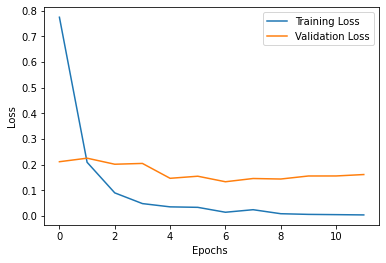

In [122]:
list_embed = [ custom_embeding_matrix, embedding_matrix_fasttext, embedding_matrix_glove, 
              embedding_matrix_word2vec ]
len_list_embed = len(list_embed)

dme_model = DME(list_embed, maxlen=max_seq_len)
history = dme_model.fit([xtrain]*len_list_embed, ytrain, validation_split = 0.2, epochs=35, batch_size=32,verbose = 1,
                   callbacks=[earlystop]
                   )

predict_test(dme_model, len_list_embed, history)

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

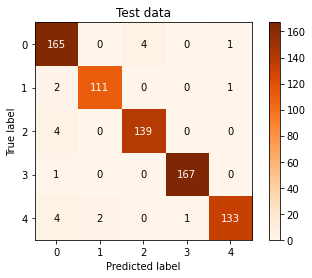

In [129]:
import scikitplot as skplt
val = len_list_embed
sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen=max_seq_len)
pred = dme_model.predict([data]*val)
y_pred = []
for pr in pred:
    p = pr.argmax()
    y_pred.append(p)
    
# label_val = ['business', 'entertainment', 'politics', 'sport', 'tech']
(skplt.metrics.plot_confusion_matrix(y_pred, le.transform(y_test), cmap='Oranges', title="Test data"))

labels_index

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(dme_model, to_file='dme_model.png', show_shapes=True, show_layer_names=True)

from PIL import Image
display(Image.open('dme_model.png'))

In [137]:
class Attention(Layer):

    def __init__(self, units=128, **kwargs):
        self.units = units
        super().__init__(**kwargs)

    def __call__(self, inputs):
        hidden_states = inputs
        hidden_size = int(hidden_states.shape[2])
        score_first_part = Dense(hidden_size, use_bias=False, 
                                 name='attention_score_vec')(hidden_states)
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), 
                     name='last_hidden_state')(hidden_states)
        score = Dot(axes=[1, 2], name='attention_score')([h_t, score_first_part])

        attention_weights = Activation('softmax', name='attention_weight')(score)
        context_vector = Dot(axes=[1, 1], name='context_vector')([hidden_states, attention_weights])
        pre_activation = Concatenate(name='attention_output')([context_vector, h_t])
        attention_vector = Dense(self.units, use_bias=False, 
                                 activation='tanh', name='attention_vector')(pre_activation)
        return attention_vector

    def get_config(self):
        return {'units': self.units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [138]:
vocab_size = len(word_index) + 1
def DME_attention(list_emb, maxlen):
    earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    inputs = []
    output = []
    proj_dim = 200
    num_emb = len(list_emb)
    
    for embedding in list_emb:
        inp = Input(shape=(maxlen,))
        emb = Embedding(vocab_size, 300, weights=[embedding], trainable=False)(inp)
        dense = Dense(proj_dim, activation=None)(emb)
        dense = Reshape((-1,proj_dim,1))(dense)
        inputs.append(inp)
        output.append(dense)
        
    concat = Concatenate(axis=-1)(output)
    
    project = Model(inputs, concat)

    inp = Input(shape=(maxlen, proj_dim, num_emb))
    x = Reshape((maxlen, proj_dim*num_emb))(inp)
    x = Dense(1, activation='sigmoid')(x)
    x = Reshape((maxlen, 1, 1))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    dme = Model(inp, out)

    x = dme(project.output)
    x = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(100, return_sequences=True))(x)
    x = Attention(32)(x)
    out = Dense(5, activation='softmax')(x)

    dme_model = Model(project.input, out)
    dme_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return dme_model


Train on 1192 samples, validate on 298 samples
Epoch 1/35
1192/1192 [==============================] - ETA: 0s - loss: 0.5823 - accuracy: 0.7398

/raid/home/devarajuv/anaconda3/envs/robotenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1192/1192 [==============================] - 11s 9ms/sample - loss: 0.5823 - accuracy: 0.7398 - val_loss: 0.3280 - val_accuracy: 0.9100
Epoch 2/35
1192/1192 [==============================] - 9s 8ms/sample - loss: 0.1275 - accuracy: 0.9526 - val_loss: 0.1215 - val_accuracy: 0.9484
Epoch 3/35
1192/1192 [==============================] - 9s 8ms/sample - loss: 0.0603 - accuracy: 0.9853 - val_loss: 0.1307 - val_accuracy: 0.9403
Epoch 4/35
1192/1192 [==============================] - 9s 8ms/sample - loss: 0.0362 - accuracy: 0.9843 - val_loss: 0.1921 - val_accuracy: 0.9014
Epoch 5/35
1192/1192 [==============================] - 9s 8ms/sample - loss: 0.0541 - accuracy: 0.9808 - val_loss: 0.2401 - val_accuracy: 0.9280
Epoch 6/35
1192/1192 [==============================] - 9s 8ms/sample - loss: 0.0327 - accuracy: 0.9859 - val_loss: 0.1494 - val_accuracy: 0.9200
Epoch 7/35
1192/1192 [==============================] - 9s 8ms/sample - loss: 0.0451 - accuracy: 0.9791 - val_loss: 0.1804 - val_accur

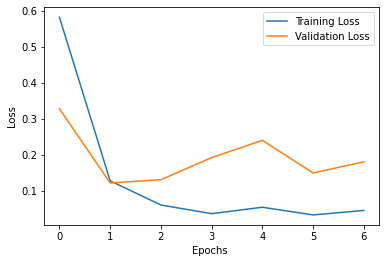

In [139]:
list_embed = [  custom_embeding_matrix, embedding_matrix_fasttext, embedding_matrix_glove, embedding_matrix_word2vec ]
len_list_embed = len(list_embed)

dme_attention_model = DME_attention(list_embed, maxlen=max_seq_len)
history = dme_attention_model.fit([xtrain]*len_list_embed, ytrain, validation_split = 0.2, epochs=35, batch_size=32,verbose = 1,
                   callbacks=[earlystop]
                   )

predict_test(dme_model, len_list_embed, history)

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

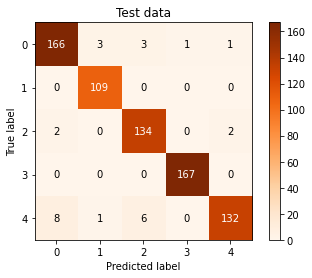

In [140]:
import scikitplot as skplt
val = 1
sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen=max_seq_len)
pred = model.predict([data]*val)
y_pred = []
for pr in pred:
    p = pr.argmax()
    y_pred.append(p)
    
(skplt.metrics.plot_confusion_matrix(y_pred, le.transform(y_test), cmap='Oranges', title="Test data"))

labels_index